In [16]:
from syngenerator import *
import numpy as np

train_gen = SynGeneratorParser.load('syn_org_data/0_0_train.json')
test_gen = SynGeneratorParser.load('syn_org_data/0_0_test.json')

X_train, y_train = train_gen.generate(seed=0)
X_test, y_test = test_gen.generate(seed=10)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))


Warning, dim [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] is not related to any 1D generator, add uniform 1d generator
Warning, dim [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] is not related to any 1D generator, add uniform 1d generator


100%|██████████| 400/400 [00:01<00:00, 322.86it/s]

(array([0., 1., 2.]), array([ 86, 445, 469], dtype=int64))
(array([0., 1., 2.]), array([ 31, 175, 194], dtype=int64))


In [17]:
from methods.methods import *
from utils import *
from metrics import *
from matplotlib import pyplot as plt
from matplotlib.pyplot import Normalize
from tqdm import tqdm

m = Methods(verbose=False, gpu_accel=True)

methods= m.available()


In [18]:

for method_name in tqdm(methods):
    try:
        method = m.get(method_name)
        method.fit(X_train)
        p_train = method.transform(X_train)
        p_test = method.transform_oos(X_test)

    except:
        print(f"Method '{method_name}' failed")
        p_train = np.zeros((0,2))
        p_test = np.zeros((0,2))
    
    save_projection(f"syn_org_data/{method_name}_train.csv", p_train)
    save_projection(f"syn_org_data/{method_name}_test.csv", p_test)


 19%|█▉        | 3/16 [01:33<08:22, 38.65s/it]

Restoring model weights from the end of the best epoch: 30.
Epoch 40: early stopping


 25%|██▌       | 4/16 [01:37<05:10, 25.84s/it]

Restoring model weights from the end of the best epoch: 22.
Epoch 32: early stopping


 31%|███▏      | 5/16 [01:42<03:24, 18.59s/it]

13/13 [==============================] - 0s 834us/step


 44%|████▍     | 7/16 [02:55<04:08, 27.63s/it]f:\Dev\OOS-DR-Benchmark\.venv\lib\site-packages\umap\parametric_umap.py:148: UserWarning: tensorflow_probability not installed or incompatible to current                 tensorflow installation. Setting global_correlation_loss_weight to zero.
  warn(


31011/31011 [==============================] - 195s 6ms/step - loss: 0.2877


 56%|█████▋    | 9/16 [06:14<06:37, 56.72s/it]

part4 (array([ True]), array([1000000], dtype=int64))


 62%|██████▎   | 10/16 [06:16<03:59, 39.99s/it]2025-02-23 01:11:08,302 - INFO - add pending dealloc: cuMemFree_v2 40000 bytes
2025-02-23 01:11:08,302 - INFO - add pending dealloc: cuStreamDestroy_v2 ? bytes
2025-02-23 01:11:08,303 - INFO - dealloc: cuStreamDestroy_v2 ? bytes
2025-02-23 01:11:08,303 - INFO - dealloc: cuStreamDestroy_v2 ? bytes
2025-02-23 01:11:08,303 - INFO - dealloc: cuStreamDestroy_v2 ? bytes
2025-02-23 01:11:08,304 - INFO - dealloc: cuStreamDestroy_v2 ? bytes
2025-02-23 01:11:08,304 - INFO - dealloc: cuStreamDestroy_v2 ? bytes
2025-02-23 01:11:08,304 - INFO - dealloc: cuStreamDestroy_v2 ? bytes
2025-02-23 01:11:08,305 - INFO - dealloc: cuStreamDestroy_v2 ? bytes
2025-02-23 01:11:08,305 - INFO - dealloc: cuStreamDestroy_v2 ? bytes
2025-02-23 01:11:08,305 - INFO - dealloc: cuStreamDestroy_v2 ? bytes
2025-02-23 01:11:08,306 - INFO - dealloc: cuStreamDestroy_v2 ? bytes
2025-02-23 01:11:08,306 - INFO - dealloc: cuStreamDestroy_v2 ? bytes
2025-02-23 01:11:08,306 - INFO - a

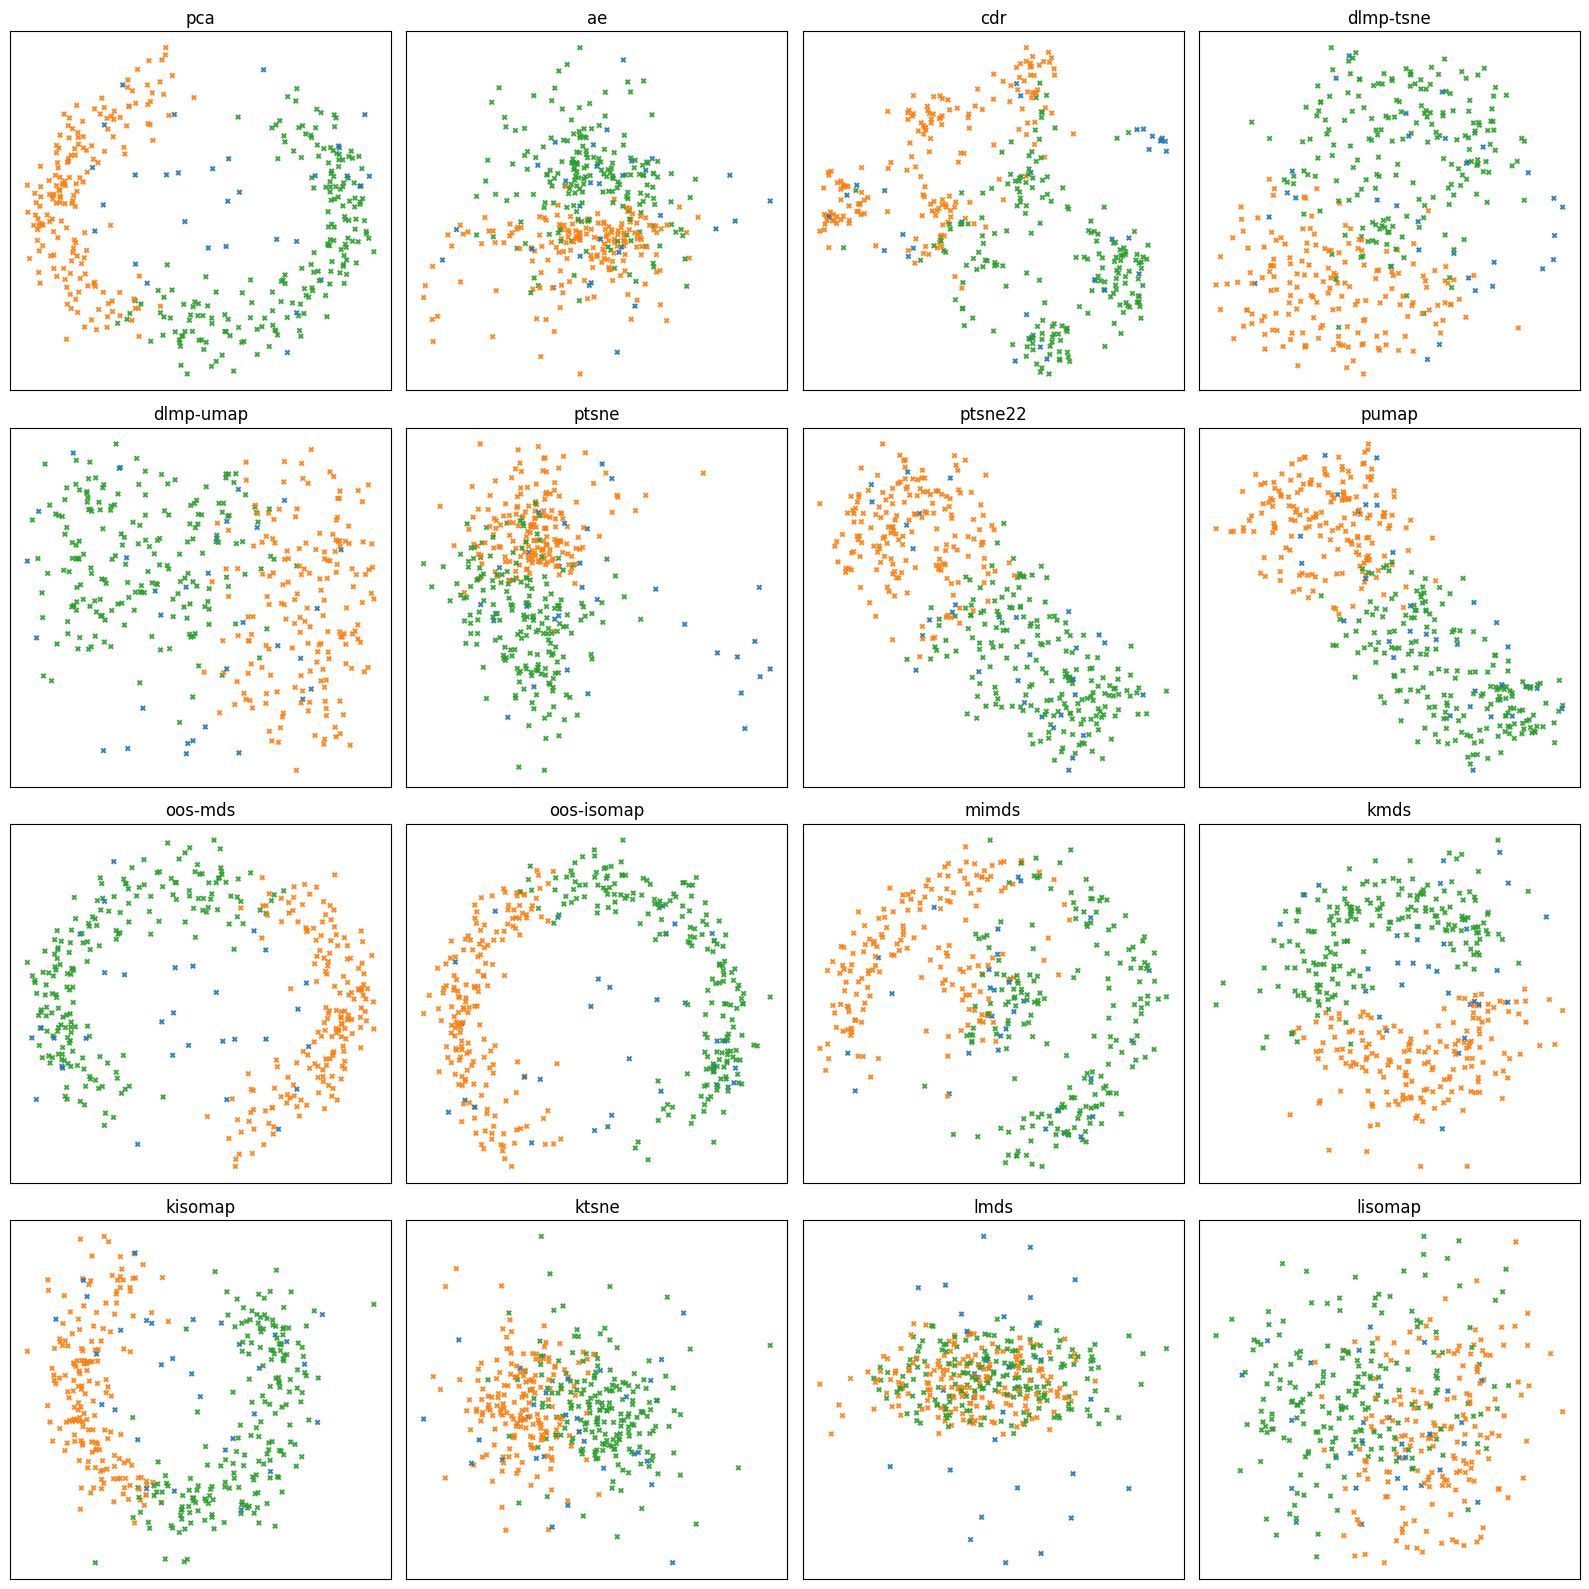

In [19]:

ncols = min(4, len(methods))
nrows = int(np.ceil(len(methods) / ncols))

fig, ax = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))

for i, method_name in enumerate(methods):

    r = i // ncols
    c = i % ncols
    p = load_projection(f"syn_org_data/{method_name}_test.csv")
    
    axes = ax[r, c] if nrows > 1 else ax[i] if ncols > 1 else ax

    axes.scatter(p[:,0], p[:,1], c=y_test, cmap='tab10', marker='x', s=10, alpha=0.9, norm=Normalize(vmin=0, vmax=9))

    axes.set_title(methods[i])
    axes.set_xticks([])
    axes.set_yticks([])

fig.tight_layout()


In [20]:
import pandas as pd

metrics = Metrics()

metrics_name = metrics.available()

metdf = pd.DataFrame(columns=metrics_name, index=methods)

for method_name in methods:
    p_train = load_projection(f"syn_org_data/{method_name}_train.csv")
    p_test = load_projection(f"syn_org_data/{method_name}_test.csv")
    metrics.update_metrics(X_train, p_train, X_test, p_test, y_train, y_test)

    for metric_idx, metric_name in enumerate(metrics_name):
        result, full_name = metrics.run_single(metric_name)
        metdf.loc[method_name, metric_name] = result


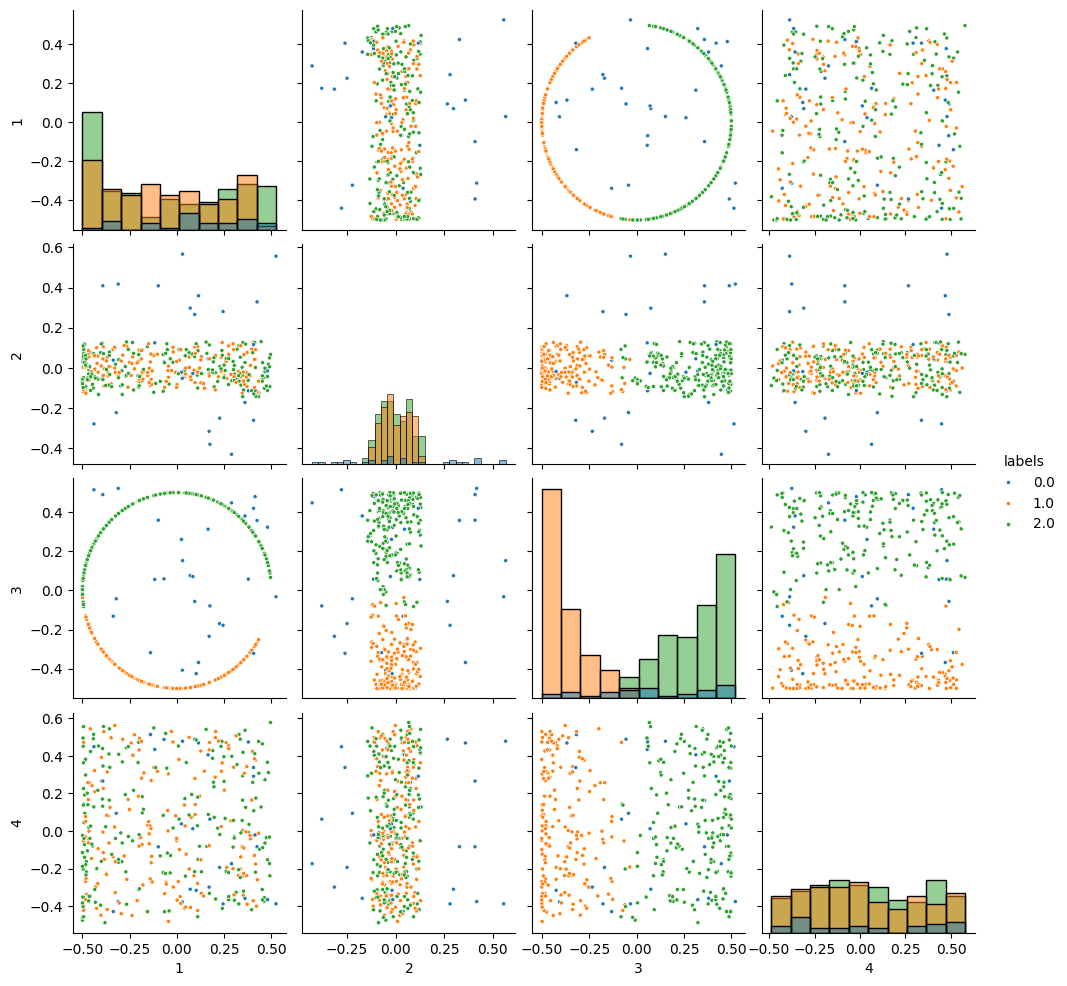

In [21]:
# 根据dataset的维度，绘制散点图矩阵
import seaborn as sns
import pandas as pd

subdata = X_test[:, :4]

df = pd.DataFrame(subdata, columns=[str(i+1) for i in range(subdata.shape[1])])
df['labels'] = y_test

sns.pairplot(df, diag_kind="hist", markers='.', hue='labels', palette='tab10')
plt.show()


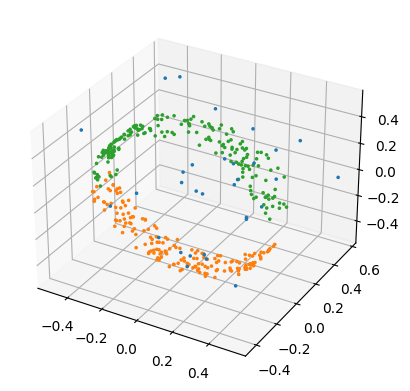

In [22]:
# 绘制三维散点图

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

selected_axis = [0,1,2]

ax.scatter(X_test[:, selected_axis[0]], X_test[:, selected_axis[1]], X_test[:, selected_axis[2]], 
           c=y_test, norm=Normalize(vmin=0, vmax=9), cmap='tab10', marker='.', s=10 ,alpha=1.0)
plt.show()